In [2]:
COLORLEFT = '#31A2AC'
COLORRIGHT = '#FF8D3F'

from bioinfokit.analys import stat
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.anova import AnovaRM

# Load modules and data
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

#Import all needed libraries
from matplotlib.lines import Line2D
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from statannot import add_stat_annotation
import itertools

from datahandler import Utils
from ast import literal_eval
from glob import glob
from open_ephys.analysis import Session
import pyopenephys
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

#### Necesitas estas librerías!
### Elephant --> https://elephant.readthedocs.io/en/latest/tutorials/statistics.html
### neo --> https://neo.readthedocs.io/en/stable/install.html

from matplotlib.backends.backend_pdf import PdfPages

from pylab import *
import scipy.io as sio
import warnings
%matplotlib inline

rcParams['figure.figsize']=(12,3)  # Change the default figure size

# ... and notebook specific modules
from scipy.stats import gamma 
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['lines.markersize'] = 7

cm = 1/2.54 

In [4]:
sns.set_context('paper')

# trials_path ='C:/Users/Tiffany/Google Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/EphysB2/clean/E22/E22_StageTraining_Ephys_V5_20211224-130951_trials.csv'
# params_path ='C:/Users/Tiffany/Google Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/EphysB2/clean/E22/E22_StageTraining_Ephys_V5_20211224-130951_params.csv'

# trials_path ='C:/Users/Tiffany/Google Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/EphysB2/clean/E22/E22_StageTraining_Ephys_V5_20211213-123257_trials.csv'
# params_path ='C:/Users/Tiffany/Google Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/EphysB2/clean/E22/E22_StageTraining_Ephys_V5_20211213-123257_params.csv'

# trials_path ='C:/Users/Tiffany/Google Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/EphysB2/clean/E16/E16_StageTraining_Ephys_V5_20211209-121716_trials.csv'
# params_path ='C:/Users/Tiffany/Google Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/EphysB2/clean/E16/E16_StageTraining_Ephys_V5_20211209-121716_params.csv'

trials_path ='C:/Users/Tiffany/Google Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/EphysB2/clean/E17/E17_StageTraining_Ephys_V5_20220224-145148_trials.csv'
params_path ='C:/Users/Tiffany/Google Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/EphysB2/clean/E17/E17_StageTraining_Ephys_V5_20220224-145148_params.csv'

# trials_path ='C:/Users/Tiffany/Google Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/EphysB2/clean/E22/E22_StageTraining_Ephys_V5_20211204-104439_trials.csv'
# params_path ='C:/Users/Tiffany/Google Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/EphysB2/clean/E22/E22_StageTraining_Ephys_V5_20211204-104439_params.csv'

obtain_path = 'C:/Users/Tiffany/Google Drive/WORKING_MEMORY/PAPER/Figures/'
save_path = 'C:/Users/Tiffany/Google Drive/WORKING_MEMORY/PAPER/Panel figures/Fig Supp. 1 Behavior examples/'
os.chdir(obtain_path)

In [5]:
def repeat_choice_side(row):
    '''
    Parameters
    ----------
    row : look row by row whether there was a repetition of LEFT response (1) or RIGHT response (2)

    Returns
    -------
    TYPE
        DESCRIPTION.

    '''
    # Compare the current response with the previous one. If that matches, return a 1 meaning it repeated. 
    if row['trials'] != 0:
        # Compare the current response with the previous one. .  
        if row['vector_answer'] == row['previous_vector_answer']:
            # if it matched and the answer was 1, it means that it repeated a right response
            if row['vector_answer'] == 1:
                return 2
            # if it matched and the answer was 0, it means that it repeated a left response
            else:
                return 1
        elif row['validhistory'] == True and row['previous_valids'] == True:
            return 0
        else:
            return np.nan
    else:
        return np.nan
  

# Psycometric curve calculation function
def psych_curve(coherences, r_resp):

    """
    Computes a psychometric function.
    """

    def sigmoid_mme(fit_params: tuple):
        k, x0, b, p = fit_params

        # Function to fit:
        y_pred = b + (1 - b - p) / (1 + np.exp(-k * (xdata - x0)))

        # Calculate negative log likelihood:
        ll = - np.sum(stats.norm.logpdf(ydata, loc=y_pred))

        return ll

    evidence = coherences/max(coherences) 
    
    # R_resp contains True if the response was on the right side, whether correct or incorrect.
    a = {'r_resp': r_resp, 'evidence': evidence, 'coh': coherences}
 
    coherence_dataframe = pd.DataFrame(a)
   
    #Count number of trials for each coherence and create a list with only those with more than 90 trials. 
    coherences_plot = []
    for i in coherence_dataframe.groupby('coh').count().iterrows():
        if i[1][0] >= 10:
            coherences_plot.append(i[0])
            
    #Filter dataframe to use only coherences selected with more than 25 trials.         
    coherence_dataframe=coherence_dataframe.loc[coherence_dataframe['coh'].isin(coherences_plot)]

    info = coherence_dataframe.groupby(['evidence'])['r_resp'].mean()
    ydata = [np.around(elem, 3) for elem in info.values]
    xdata = info.index.values
    fit_error = [np.around(elem, 3) for elem in coherence_dataframe.groupby(['evidence'])['r_resp'].sem().values]

    initial_guess = np.array([1, 1, 0, 0])

    # Run the minimizer:
    ll = minimize(sigmoid_mme, initial_guess)

    # Fit parameters:
    k, x0, b, p = [np.around(param, 2) for param in ll['x']]

    # Compute the fit with 30 points:
    fit = b + (1 - b - p) / (1 + np.exp(-k * (np.linspace(-1, 1, 30) - x0)))
    fit = [np.around(elem, 3) for elem in fit]

    params=[k, x0, b, p]

    coherence_dataframe.groupby('coh').count()

    return fit,params,xdata,ydata,fit_error

def create_duration_states(df,params):
    ''' Creates new columns with duration of certain states '''
    state_list = params.state_list.split(',')
    
    for state in state_list:
        df[state + '_duration'] = df[state + '_end'] - df[state + '_start']

    return df

def alignment(df,params,zero):
        ''' Substract to timestamps of a dataframe a specific value to set the 0 in different positions 
            Takes:
                df = Dataframe of trials
                params = list with overall session values
                zero = State at from which reset timing
        '''
        
        state_list = params.state_list.split(',')
        
        df = Utils.convert_strings_to_lists(df, ['Fixation_end','Fixation_start','Fixation_Break_start','Fixation_Break_end','L_s', 'C_s','C_e','L_e'])
        
        if params.lick == 2:
            df = Utils.convert_strings_to_lists(df, ['ResponseWindow_start','ResponseWindow_end','SecondWrongLick_start','SecondWrongLick_end','SecondCorrectLick_start', 'SecondCorrectLick_end'])
            
        # Shifts the alignment to StimulusTrigger
        alignment = []
        for j in df[zero]:
            alignment.append(float(j[-1]))
            
        for state in state_list:
            try:
                df[state+'_start'] = df[state+'_start']-alignment
                df[state+'_end'] = df[state+'_end']-alignment
            except:
                pass
                
        df['L_s'] = df['L_s'] - alignment
        df['L_e'] = df['L_e'] - alignment
        df['C_s'] = df['C_s'] - alignment
        df['C_e'] = df['C_e'] - alignment
                                 
        return df

In [6]:
try:
    df = pd.read_csv(trials_path, sep=';')
except FileNotFoundError:
    logger.critical("Error: Reading trials CSV file. Exiting...")
    raise

try:
    params = pd.read_csv(params_path, sep=';')
except FileNotFoundError:
    logger.critical("Error: Reading params CSV file. Exiting...")
    raise

df.index = df.trials

# transform params df that only contains one row in a Series object
params = params.iloc[0]

try:
    df = Utils.convert_strings_to_floats(df, ['ResponseWindow_start','ResponseWindow_end', 'AW_start','StimulusDuration_start',
                                                  'StimulusDuration_end','StimulusTrigger_end', 'StimulusTrigger_start',
                                                  'Reward_start','Miss_start','Punish_start','WrongLick_start',
                                                 'AW_start', 'StimulusTrigger_end', 
                                                 ])     
except KeyError:
    df = Utils.convert_strings_to_floats(df, ['ResponseWindow_start','ResponseWindow_end', 'StimulusDuration_start',
                                                  'StimulusDuration_end','StimulusTrigger_end', 'StimulusTrigger_start',
                                                  'Reward_start','Miss_start','Punish_start','WrongLick_start',
                                                 'StimulusTrigger_end', 
                                                 ])           
if params.timeout != 0:
    df = Utils.convert_strings_to_floats(df, ['TimeOut_end', 'TimeOut_start'])    

if params.motor >= 6:
    df = Utils.convert_strings_to_floats(df, ['Delay_end', 'Delay_start'])    

if  params.fixation >= 0.1:
    try:
        df = alignment(df,params,'ResponseWindow_start')
    except KeyError:
        params.fixation = 0
        df = Utils.convert_strings_to_lists(df, ['L_s', 'C_s','C_e','L_e'])       
else:
    df = Utils.convert_strings_to_lists(df, ['L_s', 'C_s','C_e','L_e'])

vector_answer_dev = np.logical_not(np.logical_xor(df['reward_side'], df['hithistory'].astype(int)))
vector_answer = np.where(vector_answer_dev==False, -1, 1)
vector_answer=(vector_answer +1)/2

df['vector_answer'] = vector_answer
df['repeat_choice'] = np.nan
df['alternate_choice'] = np.nan

for i in range(len(df)):
    if df['trials'].iloc[i] != 0:
        if df['vector_answer'].iloc[i-1] == df['vector_answer'].iloc[i]:
            df['repeat_choice'].iloc[i] = 1  # Repeat previous choice
        else:
            df['repeat_choice'].iloc[i] = 0 # Alternate previous choice
            
for i in range(len(df)):
    if df['trials'].iloc[i] != 0:
        if df['vector_answer'].iloc[i-1] != df['vector_answer'].iloc[i]:
            df['alternate_choice'].iloc[i] = 1  # Repeat previous choice
        else:
            df['alternate_choice'].iloc[i] = 0 # Alternate previous choice
            
# EXPANDED DATAFRAMES
try:
    pokes_df_left = Utils.unnesting(df, ['L_s', 'L_e'])
    pokes_df_right = Utils.unnesting(df, ['C_s', 'C_e'])    
except:
    df = df.applymap(lambda x: x if not isinstance(x, np.ndarray) else x[0] if len(x) else '')
    pokes_df_left = Utils.unnesting(df, ['L_s', 'L_e'])
    pokes_df_right = Utils.unnesting(df, ['C_s', 'C_e'])   
    pass

#Duration of states for faster raster plot
#df = create_duration_states(df,params)

# SUB-DATAFRAMES    
left_trials_df = df[df.reward_side == 0]
right_trials_df = df[df.reward_side == 1]

valid_trials_df = df[df.misshistory == False]
left_valid_trials_df = valid_trials_df[valid_trials_df.reward_side == 0]
right_valid_trials_df = valid_trials_df[valid_trials_df.reward_side == 1]

if params.motor == 6 and params.catch != 5:    
    if params.delay_progression_value == 0 and params.delay_l != params.delay_h:
        df_l = df[df['delay_times'] == sorted(df.delay_times.unique())[0]]
        df_m = df[df['delay_times'] ==  sorted(df.delay_times.unique())[1]]
        df_h = df[df['delay_times'] ==  sorted(df.delay_times.unique())[-1]]
    else:
        df_l = df[df['delay_types'] == 'delay_l']
        df_m = df[df['delay_types'] == 'delay_m']
        df_h = df[df['delay_types'] == 'delay_h']

# USEFUL VALUES
number_of_trials = df.shape[0]

# Measure accuracy of the session assuming that wronglicks were punishes. 
if params.stage_number == 1:
    correct_licks = 'wronglickhistory'

else:   
    correct_licks = 'hithistory'

corrects_left = left_trials_df[left_trials_df[correct_licks] == 1].shape[0]
total_left = left_trials_df.shape[0]
per_left = corrects_left / total_left

corrects_right = right_trials_df[right_trials_df[correct_licks] == 1].shape[0]
total_right = right_trials_df.shape[0]
try:
    per_right = corrects_right / total_right
except:
    per_right = 0

per_accuracy = df[df[correct_licks]==1].shape[0] / params.valid_trials
per_invalids = params.invalid_trials / params.total_trials
per_performance = params.correct_trials / params.total_trials

valid_left = left_valid_trials_df.shape[0]
try:
    acc_left = corrects_left / valid_left
except:
    acc_left = 0

valid_right = right_valid_trials_df.shape[0]
try:
    acc_right = corrects_right / valid_right
except:
    acc_right = 0

miss_left = left_trials_df[left_trials_df.misshistory == True].shape[0]
try:
    m_left = miss_left / total_left
except:
    m_left = 0

miss_right = right_trials_df[right_trials_df.misshistory == True].shape[0]
try:
    m_right = miss_right / total_right 
except:
    m_right= 0
AWwater = df.loc[(df.AWhistory == True)]['trials'].count()

prob_repeat_incorrect=df.loc[(df['validhistory']==1)]['repeat_choice'].mean()/df.loc[(df['validhistory']==1) & (df['after_correct'] == 0)]['repeat_choice'].mean()
prob_repeat_correct=df.loc[(df['validhistory']==1)]['repeat_choice'].mean()/df.loc[(df['validhistory']==1) & (df['after_correct'] == 1)]['repeat_choice'].mean()

c:\users\tiffany\google drive\working_memory\experiments\analysis codes\datahandler\datahandler\utils.py:112: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  finaldf = df1.join(df.drop(explode, 1), how='left')


**Accuracy plot**

C:\Users\Tiffany\Anaconda3\envs\envr\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Tiffany\Anaconda3\envs\envr\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


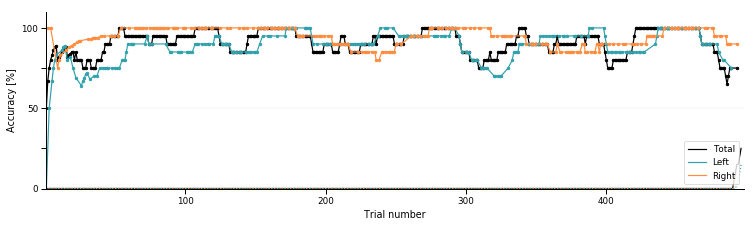

In [7]:
# cm = 1/2.54 
# H=3.5
# V=1
# plt.figure(figsize=((4.4*cm)*H, (3.8*cm)*V))        

plt.figure(figsize=(12.5,3.25))     

# ---------------------- FIRST PLOT: rolling averages of accuracy -------------------------------------            
# Prepares the grid for the plots
axes = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1)
ra_total = Utils.compute_window(valid_trials_df.hithistory, 20)
ra_right = Utils.compute_window(right_valid_trials_df.hithistory, 20)
ra_left = Utils.compute_window(left_valid_trials_df.hithistory, 20)

axes.plot(valid_trials_df.trials, ra_total,  color='black',marker='.')
axes.plot(left_valid_trials_df.trials, ra_left, color=COLORLEFT,marker='.')
axes.plot(right_valid_trials_df.trials, ra_right,  color=COLORRIGHT, marker='.')


# ---------------------- Misses -------------------------------------            
# Prepares the grid for the plots
ra_total = Utils.compute_window(df.misshistory, 20)
ra_right = Utils.compute_window(right_trials_df.misshistory, 20)
ra_left = Utils.compute_window(left_trials_df.misshistory, 20)

axes.plot(df.trials, ra_total,  color='black', markersize=4)
axes.plot(left_trials_df.trials, ra_left, color=COLORLEFT, linestyle=':',markersize=4)
axes.plot(right_trials_df.trials, ra_right,  color=COLORRIGHT, linestyle=':', markersize=4)

axes.set_ylabel('Accuracy [%]')      
axes.set_ylim([0, 1.1])
axes.set_yticks(list(np.arange(0, 1.1, 0.25)))
axes.set_yticklabels(['0', '',  '50',  '', '100'])

axes.set_xlim([1, number_of_trials + 1])
axes.set_xlabel('Trial number')
axes.yaxis.set_tick_params()
axes.xaxis.set_tick_params()
axes.hlines(xmin=0, xmax=number_of_trials + 1, y=0.5, linewidth=0.2, color='gray',linestyle = ':')

legend_elements = [Line2D([0], [0], color='black', label='Total'),
                   Line2D([0], [0], color=COLORLEFT, label='Left'),
                   Line2D([0], [0], color=COLORRIGHT, label='Right')]
axes.legend(loc="lower right", handles=legend_elements, ncol=1)      

sns.despine()

plt.savefig(save_path+'/Accuracy progression in one session.svg', dpi =300, bbox_inches='tight')   

**Miss plot**

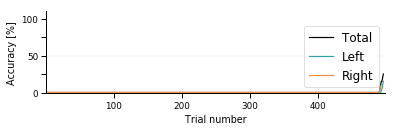

In [8]:
H=3.5
V=1
plt.figure(figsize=((4.4*cm)*H, (3.8*cm)*V))        

# ---------------------- FIRST PLOT: rolling averages of accuracy -------------------------------------            
# Prepares the grid for the plots
axes = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1)
ra_total = Utils.compute_window(df.misshistory, 20)
ra_right = Utils.compute_window(right_trials_df.misshistory, 20)
ra_left = Utils.compute_window(left_trials_df.misshistory, 20)

axes.plot(df.trials, ra_total,  color='black', markersize=4)
axes.plot(left_trials_df.trials, ra_left, color=COLORLEFT, markersize=4)
axes.plot(right_trials_df.trials, ra_right,  color=COLORRIGHT, markersize=4)

axes.set_ylabel('Accuracy [%]')      
axes.set_ylim([0, 1.1])
axes.set_yticks(list(np.arange(0, 1.1, 0.25)))
axes.set_yticklabels(['0', '',  '50',  '', '100'])

axes.set_xlim([1, number_of_trials + 1])
axes.set_xlabel('Trial number')
axes.yaxis.set_tick_params()
axes.xaxis.set_tick_params()
axes.hlines(xmin=0, xmax=number_of_trials + 1, y=0.5, linewidth=0.2, color='gray',linestyle = ':')

legend_elements = [Line2D([0], [0], color='black', label='Total'),
                   Line2D([0], [0], color=COLORLEFT, label='Left'),
                   Line2D([0], [0], color=COLORRIGHT, label='Right')]
axes.legend(loc="lower right", handles=legend_elements, ncol=1, prop={'size': 12})      

sns.despine()

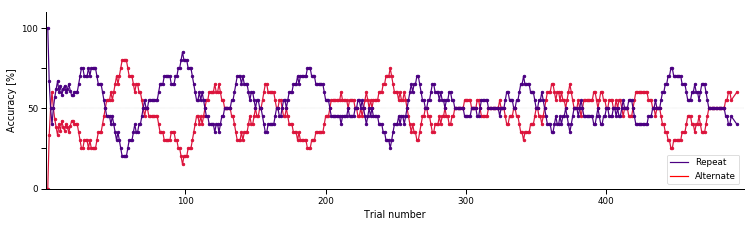

In [9]:
# cm = 1/2.54 
# H=3.5
# V=1
# plt.figure(figsize=((4.4*cm)*H, (3.8*cm)*V))        

plt.figure(figsize=(12.5,3.25))     

# ---------------------- FIRST PLOT: rolling averages of accuracy -------------------------------------            
# Prepares the grid for the plots
axes = plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1)
# ra_total = Utils.compute_window(valid_trials_df.repeat_choice, 20)
ra_right = Utils.compute_window(valid_trials_df.repeat_choice, 20)
ra_left = Utils.compute_window(valid_trials_df.alternate_choice, 20)

# axes.plot(valid_trials_df.trials, ra_total,  color='black',marker='.')
axes.plot(valid_trials_df.trials, ra_left, color='crimson',marker='.')
axes.plot(valid_trials_df.trials, ra_right,  color='indigo', marker='.')

axes.set_ylabel('Accuracy [%]')      
axes.set_ylim([0, 1.1])
axes.set_yticks(list(np.arange(0, 1.1, 0.25)))
axes.set_yticklabels(['0', '',  '50',  '', '100'])

axes.set_xlim([1, number_of_trials + 1])
axes.set_xlabel('Trial number')
axes.yaxis.set_tick_params()
axes.xaxis.set_tick_params()
axes.hlines(xmin=0, xmax=number_of_trials + 1, y=0.5, linewidth=0.2, color='gray',linestyle = ':')

legend_elements = [
                   Line2D([0], [0], color='indigo', label='Repeat'),
                   Line2D([0], [0], color='red', label='Alternate')]
axes.legend(loc="lower right", handles=legend_elements, ncol=1)      

sns.despine()

plt.savefig(save_path+'/Prob.Repeat progression in one session.svg', dpi =300, bbox_inches='tight')   

In [10]:
# plt.figure(figsize=(12.5, 13.7))        

# # Prepares the grid for the plots
# axes = plt.subplot2grid((14,1), (0,0), colspan=2, rowspan=3)

# # ________________ THIRD PLOT: SCATTER PLOT________________________________
# conditions = [df.hithistory == 1, df.hithistory == 0,  df.misshistory == 1, df.wronglickhistory == True]
# choices = [ 'green','red', 'black', 'grey']

# df['color'] = np.select(conditions, choices)


# # 
# if params.stage_number <= 3 and params.motor != 6.0:
#     ncol = len(df.color.unique())
#     axes = plt.subplot2grid((16,2), (4,0), colspan=2, rowspan=1)
#     sns.scatterplot(df.trials, df.reward_side, hue=df.color, palette=choices[:ncol], s=8, ax=axes, linewidth=0.1)

#     axes.set_ylim(-0.8, 1.8)
#     axes.set_yticks([0, 1])
#     axes.set_yticklabels(['Left', 'Right'])
#     axes.set_ylabel('Sides')

# elif params.motor == 6.0:
#     #Transform some values of ddelay to asess the side. Negative delay values are left trials and positive, right. 
#     def transform_side(row):
#         if row.reward_side == 0:
#             return row.delay_times
#         else:
#             print(-row.delay_times)
#             return -row.delay_times

#     df['delay_times_side'] = df.apply(transform_side, axis=1)

#     ncol = len(df[df['reward_side']==0].color.unique())
#     axes = plt.subplot2grid((16,2), (4,0), colspan=2, rowspan=1)
#     sns.scatterplot('trials', 'delay_times_side', hue='color',data=df[df['reward_side']==0], legend=False, palette=choices[:ncol], s=8, ax=axes, linewidth=0.1)
#     axes.set_ylabel('Left')

#     ncol = len(df[df['reward_side']==1].color.unique())
#     axes = plt.subplot2grid((16,2), (5,0), colspan=2, rowspan=1)
#     sns.scatterplot('trials', 'delay_times_side', hue='color',data=df[df['reward_side']==1], legend=False, palette=choices[:ncol], s=8, ax=axes, linewidth=0.1)
#     axes.set_ylabel('Right')

# else:
#     ncol = len(df.color.unique())
#     axes = plt.subplot2grid((16,2), (4,0), colspan=2, rowspan=1)
#     sns.scatterplot(df.trials, df.reward_side, hue=df.color, palette=choices[:ncol], s=8, ax=axes, linewidth=0.1)
#     axes.set_ylim(-0.8, 1.8)
#     axes.set_yticks([0, 1])
#     axes.set_yticklabels(['Left', 'Right'])
#     axes.set_ylabel('Sides')

#     axes = plt.subplot2grid((16,2), (5,0), colspan=2, rowspan=2)
#     sns.scatterplot(df.trials, df.coherences, hue=df.color, palette=choices[:ncol], s=12, ax=axes, linewidth=0.1)
#     axes.set_ylim(-26, 26)
#     axes.set_yticks([-24,-16,-8,0,8,16,24])
#     axes.set_ylabel('Coherences')

# axes.set_xlim([1, number_of_trials + 1])        
# axes.set_xticklabels([])  

Let's do the raster


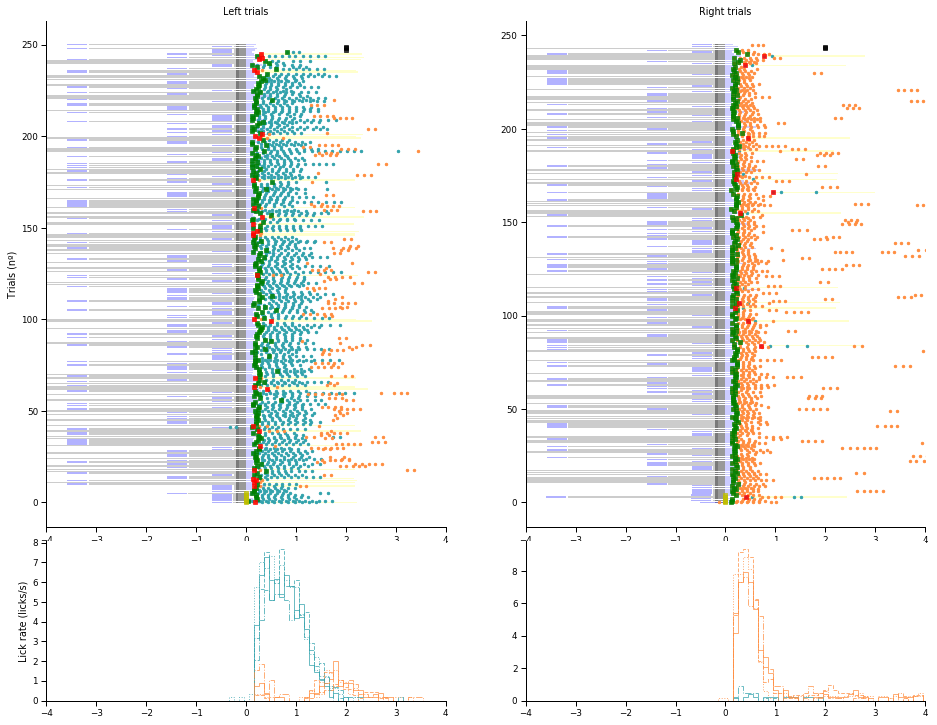

In [11]:
cm = 1/2.54
plt.figure(figsize=(15.75, 12.5))        
# ____________________ FORTH PLOT: RASTER PLOT ________________________________________________
print("Let's do the raster")
BINSIZE=0.1
# Plotting a square marker for relevant trial conclusion. Had to remove the last trial because of reward list errors. 

colors = ['g','r','y','k']
states = ['Reward_start','Punish_start','AW_start','Miss_start']

axes1 = plt.subplot2grid((8,2), (0,0), colspan=1, rowspan=6)
axes3 = plt.subplot2grid((8,2), (0,1), colspan=1, rowspan=6)

axes2 = plt.subplot2grid((8,2),(6,0), colspan=1, rowspan=2) 
axes4 = plt.subplot2grid((8,2),(6,1), colspan=1, rowspan=2) 

axes1.set_title('Left trials')
axes3.set_title('Right trials')

# _________ Plot reward, punish, AW and miss for box sides _____________
for color, state in zip(colors,states):
    try:
        axes1.scatter(df.loc[df.reward_side == 0][state][:-1],range(len(df.index[df.reward_side == 0][:-1])), marker = 's', color=color, alpha = 0.8, s=10, zorder=2)
        axes3.scatter(df.loc[df.reward_side == 1][state][:-1],range(len(df.index[df.reward_side == 1][:-1])), marker = 's', color=color, alpha = 0.8,  s=10, zorder=2)
    except KeyError:
        pass           
# ________ Plot raster of licks, one dot for each portin. _________
col = 0
truevalue = 0
colors = [COLORLEFT,COLORRIGHT]

for columns in df[['L_s','C_s']]:
    
    # Plot for licks for left trials
    j=0
    color = colors[col]
    col+=1
    histogram = []
    for sublist in df.loc[df.reward_side == 0, str(columns)]:
        axes1.plot(np.array(sublist),np.repeat(j, len(sublist),axis =0), '.', color=color, zorder=1)
        j+=1                       
        for item in sublist:
            histogram.append(item)

    # Plot for licks for right trials
    j=0
    histogram = []
    for sublist in df.loc[df.reward_side == 1, str(columns)]:
        axes3.plot(np.array(sublist),np.repeat(j, len(sublist),axis =0), '.',color=color, zorder=1)
        j+=1
        for item in sublist:
            histogram.append(item)

for delay, style in zip(df.delay_times.unique(),[':','--','-','-.']):
    axes2.hist(pokes_df_left.loc[(pokes_df_left.delay_times==delay)&(pokes_df_left.reward_side==0)]['L_s'].dropna(), linestyle=style, bins=np.arange(-0.5, 4, BINSIZE),align = 'right', linewidth=1, edgecolor=COLORLEFT, histtype='step',alpha=0.7, color=COLORLEFT, weights=np.repeat((1/len(left_valid_trials_df.loc[left_valid_trials_df.delay_times ==delay]))/BINSIZE,len(pokes_df_left.loc[(pokes_df_left.delay_times==delay)&(pokes_df_left.reward_side==0)]['L_s'].dropna())))
    axes2.hist(pokes_df_right.loc[(pokes_df_right.delay_times==delay)&(pokes_df_right.reward_side==0)]['C_s'].dropna(), linestyle=style, bins=np.arange(-0.5, 4, BINSIZE),align = 'right', linewidth=1, edgecolor=COLORRIGHT, histtype='step',alpha=0.7, color=COLORRIGHT, weights=np.repeat((1/len(left_valid_trials_df.loc[left_valid_trials_df.delay_times ==delay]))/BINSIZE,len(pokes_df_right.loc[(pokes_df_right.delay_times==delay)&(pokes_df_right.reward_side==0)]['C_s'].dropna())))

    axes4.hist(pokes_df_left.loc[(pokes_df_left.delay_times==delay)&(pokes_df_left.reward_side==1)]['L_s'].dropna(), linestyle=style, bins=np.arange(-0.5, 4, BINSIZE),align = 'right', linewidth=1, edgecolor=COLORLEFT, histtype='step',alpha=0.7, color=COLORLEFT, weights=np.repeat((1/len(right_valid_trials_df.loc[right_valid_trials_df.delay_times ==delay]))/BINSIZE,len(pokes_df_left.loc[(pokes_df_left.delay_times==delay)&(pokes_df_left.reward_side==1)]['L_s'].dropna())))
    axes4.hist(pokes_df_right.loc[(pokes_df_right.delay_times==delay)&(pokes_df_right.reward_side==1)]['C_s'].dropna(), linestyle=style, bins=np.arange(-0.5, 4, BINSIZE),align = 'right', linewidth=1, edgecolor=COLORRIGHT, histtype='step',alpha=0.7, color=COLORRIGHT, weights=np.repeat((1/len(right_valid_trials_df.loc[right_valid_trials_df.delay_times ==delay]))/BINSIZE,len(pokes_df_right.loc[(pokes_df_right.delay_times==delay)&(pokes_df_right.reward_side==1)]['C_s'].dropna())))
    
for side in [0,1]:
    if side == 0:
        axes = axes1
    else:
        axes = axes3

    for i, j in zip(range(len(df.reward_side == side)),df.loc[(df['reward_side'] == side)]['trials']):
         try:
             axes.barh(i, df['TimeOut_end'][j]-df['TimeOut_start'][j],left = df['TimeOut_start'].tolist()[j], color='yellow', alpha=0.2) 
         except:
             pass

         try:
             axes.barh(i, df['Delay_end'].tolist()[j]-df['Delay_start'].tolist()[j],left = df['Delay_start'].tolist()[j], color='black', alpha=0.2) 
         except:
             pass
            
         try:
             axes.barh(i, df['ResponseWindow_start'].tolist()[j]-df['ResponseWindow_start'].tolist()[j]-0.2,left = df['ResponseWindow_start'].tolist()[j], color='black', alpha=0.4) 
         except:
             pass
            
         # try:
         #     axes.barh(i, -df['Fixation_start'].tolist()[j][0], left = df['Fixation_start'].tolist()[j][0], color='grey', alpha=0.3) 
         # except:
         #     pass

         axes.barh(i, df['StimulusDuration_end'][j]-df['StimulusDuration_start'].tolist()[j],left = df['StimulusDuration_start'].tolist()[j],color='blue', alpha=0.3) 
         axes.barh(i, df['ResponseWindow_end'][i]-df['ResponseWindow_start'].tolist()[i],left = df['ResponseWindow_start'].tolist()[j],color='blue', alpha=0.2) 

axes1.set_xlim(-4,4)
axes2.set_xlim(-4,4)
axes3.set_xlim(-4,4)
axes4.set_xlim(-4,4)

axes1.set_ylabel('Trials (nº)')
axes2.set_ylabel('Lick rate (licks/s)')
sns.despine()
plt.savefig(save_path+'/Raster plot in one session.svg', dpi =300, bbox_inches='tight')   

In [ ]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

sns.lineplot(x='delay_times',y='hithistory',data=df, marker='o', color='black',ax=ax[0], legend=False,err_style=None)
ax[0].set_ylim(0.4,1)
ax[0].hlines(xmin=0, xmax=10, y=0.5, linestyles=':')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Delay duration (s)')

sns.lineplot(x='delay_times',y='hithistory',data=df, hue='reward_side', palette=[COLORLEFT,COLORRIGHT], marker='o', ax=ax[1], legend=False,err_style=None)
ax[1].set_ylim(0.4,1)
ax[1].hlines(xmin=0, xmax=10, y=0.5, linestyles=':')
ax[1].set_xlabel('Delay duration (s)')
ax[1].set_ylabel('Accuracy')

sns.despine()
plt.tight_layout()

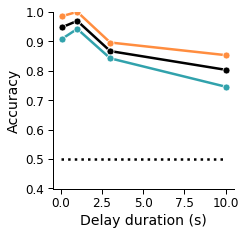

In [60]:
H=1
V=1
# fig, ax = plt.subplots(1,1,  figsize=((4.4*cm)*H, (3.8*cm)*V))
fig, ax = plt.subplots(1,1,  figsize=(3.25,3.25))

sns.lineplot(x='delay_times',y='hithistory',data=df, marker='o', color='black', legend=False,err_style=None)
sns.lineplot(x='delay_times',y='hithistory',data=df, hue='reward_side', palette=[COLORLEFT,COLORRIGHT], marker='o', legend=False,err_style=None)

ax.set_ylim(0.4,1)
ax.hlines(xmin=0, xmax=10, y=0.5, linestyles=':')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Delay duration (s)')

sns.despine()
plt.savefig(save_path+'/Example session_one.svg', dpi =300, bbox_inches='tight')   

In [79]:
df['previous_vector_answer'] = df['vector_answer'].shift(1)
df['previous_valids'] = df['validhistory'].shift(1)
df['repeat_choice_side'] = df.apply(repeat_choice_side, axis=1)

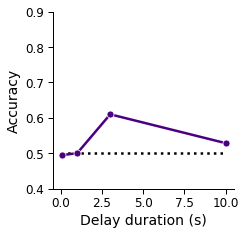

In [81]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(3.25,3.25))
# Animals that have a bigger than usual tendency to repeat and look weird in the plot
groupings=['delay_times']
df_results = pd.DataFrame()
df_results['repeat_choice'] = 0.5* df.loc[(df['repeat_choice_side']==1)].groupby(groupings)['validhistory'].count()/df.loc[(df.vector_answer == 0)].groupby(groupings)['validhistory'].count() + 0.5*df.loc[(df['repeat_choice_side']==2)].groupby(groupings)['validhistory'].count()/df.loc[(df.vector_answer == 1)].groupby(groupings)['validhistory'].count()
# df_results['repeat_choice'] =df.loc[(df['presented_delays']==presented_delay)].groupby(groupings)['repeat_choice'].mean()
df_results.reset_index(inplace=True)

sns.lineplot(x='delay_times',y='repeat_choice',data=df_results, legend=False, marker='o', color = 'indigo', ax=ax, err_style=None)
# sns.lineplot(x='delay_times',y='alternate_choice',data=df, legend=False, marker='o', color = 'indigo', ax=ax, err_style=None)

plt.ylim(0.4,0.9)
ax.hlines(xmin=0, xmax=10, y=0.5, linestyles=':')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Delay duration (s)')

sns.despine()
plt.savefig(save_path+'/Rep. Bias in one session.svg', dpi =300, bbox_inches='tight')   

In [116]:
#     else:           
#         # Prepares the grid for the plots                      
#         axes1 = plt.subplot2grid((16,2), (8,0), colspan=1, rowspan=2)
#         axes2 = plt.subplot2grid((16,2),(8,1), colspan=1, rowspan=2) 
#         axes3 = plt.subplot2grid((16,2), (10,0), colspan=1, rowspan=2)
#         axes4 = plt.subplot2grid((16,2),(10,1), colspan=1, rowspan=2) 
#         axes5 = plt.subplot2grid((16,2), (12,0), colspan=1, rowspan=2)
#         axes6 = plt.subplot2grid((16,2), (12,1), colspan=1, rowspan=2)
#         axes7 = plt.subplot2grid((16,2), (14,0), colspan=1, rowspan=2)
#         axes8 = plt.subplot2grid((16,2), (14,1), colspan=1, rowspan=2)

#         for color, state in zip(colors,states):
#             axes1.scatter(df_l.loc[df_l.reward_side == 0][state].tolist(),range(len(df_l.index[df_l.reward_side == 0])), marker = 's', color=color, alpha = 0.8, zorder=2)
#             axes2.scatter(df_l.loc[df_l.reward_side == 1][state].tolist(),range(len(df_l.index[df_l.reward_side == 1])), marker = 's', color=color, alpha = 0.8, zorder=2)
#             axes3.scatter(df_m.loc[df_m.reward_side == 0][state].tolist(),range(len(df_m.index[df_m.reward_side == 0])), marker = 's', color=color, alpha = 0.8, zorder=2)
#             axes4.scatter(df_m.loc[df_m.reward_side == 1][state].tolist(),range(len(df_m.index[df_m.reward_side == 1])), marker = 's', color=color, alpha = 0.8, zorder=2)
#             axes5.scatter(df_h.loc[df_h.reward_side == 0][state].tolist(),range(len(df_h.index[df_h.reward_side == 0])), marker = 's', color=color, alpha = 0.8, zorder=2)
#             axes6.scatter(df_h.loc[df_h.reward_side == 1][state].tolist(),range(len(df_h.index[df_h.reward_side == 1])), marker = 's', color=color, alpha = 0.8, zorder=2)

#         # Prints the states in box types of trials.      
#         for axes,df,line_type in zip([axes1,axes3,axes5,],[df_l,df_m,df_h],[':','-','--']):
#             for i in range(len(df.loc[df.reward_side == 0])): 
#                 axes.barh(i, df.loc[df.reward_side == 0]['StimulusDuration_end'].tolist()[i]-df.loc[df.reward_side == 0]['StimulusDuration_start'].tolist()[i],left = df.loc[df.reward_side == 0]['StimulusDuration_start'].tolist()[i],color='blue', alpha=0.6) 
#                 axes.barh(i, float(df.loc[df.reward_side == 0]['TimeOut_end'].tolist()[i])-df.loc[df.reward_side == 0]['TimeOut_start'].tolist()[i],left = df.loc[df.reward_side == 0]['TimeOut_start'].tolist()[i],color='yellow', alpha=0.3) 
#                 axes.barh(i, float(df.loc[df.reward_side == 0]['ResponseWindow_start'].tolist()[i])-df.loc[df.reward_side == 0]['Delay_start'].tolist()[i],left = df.loc[df.reward_side == 0]['Delay_start'].tolist()[i],color='grey', alpha=0.3) 

#             #Change axis
#             if axes == axes1:
#                 axes = axes2
#             elif axes == axes3:
#                 axes = axes4
#             elif axes == axes5:
#                 axes = axes6        

#             for i in range(len(df.loc[df.reward_side == 1])): 
#                 axes.barh(i, df.loc[df.reward_side == 1]['StimulusDuration_end'].tolist()[i]-df.loc[df.reward_side == 1]['StimulusDuration_start'].tolist()[i],left = df.loc[df.reward_side == 1]['StimulusDuration_start'].tolist()[i],color='blue', alpha=0.6) 
#                 axes.barh(i, float(df.loc[df.reward_side == 1]['TimeOut_end'].tolist()[i])-df.loc[df.reward_side == 1]['TimeOut_start'].tolist()[i],left = df.loc[df.reward_side == 1]['TimeOut_start'].tolist()[i],color='yellow', alpha=0.3) 
#                 axes.barh(i, float(df.loc[df.reward_side == 1]['ResponseWindow_start'].tolist()[i])-df.loc[df.reward_side == 1]['Delay_start'].tolist()[i],left = df.loc[df.reward_side == 1]['Delay_start'].tolist()[i],color='grey', alpha=0.3)

#         for axes,df,line_type in zip([axes1,axes3,axes5,],[df_l,df_m,df_h],[':','-','--']):    
#             col = 0
#             colors = [COLORLEFT,COLORRIGHT]
#             for columns in df[['L_s','C_s']]:
#                 #Change axis
#                 if axes == axes2:
#                     axes = axes1
#                 elif axes == axes4:
#                     axes = axes3
#                 elif axes == axes6:
#                     axes = axes5  

#                 j=0
#                 color = colors[col]
#                 col+=1
#                 histogram = []
#                 for sublist in df.loc[df.reward_side == 0, str(columns)]:
#                     axes.plot(np.array(sublist),np.repeat(j, len(sublist),axis =0), '.', color=color, zorder=1)
#                     j+=1                        
#                     for item in sublist:
#                         histogram.append(item)

#                 axes7.hist(pd.Series(histogram).dropna(),bins=np.arange(-4, 7, BINSIZE),align = 'right', linestyle = line_type,edgecolor=color, histtype='step',alpha=0.7, color=color,weights=np.repeat((1/len(left_trials_df))/0.1,len(pd.Series(histogram).dropna()))) 

#                 #Change axis
#                 if axes == axes1:
#                     axes = axes2
#                 elif axes == axes3:
#                     axes = axes4
#                 elif axes == axes5:
#                     axes = axes6     

#                 j=0
#                 histogram = []

#                 for sublist in df.loc[df.reward_side == 1, str(columns)]:
#                     axes.plot(np.array(sublist),np.repeat(j, len(sublist),axis =0), '.',color=color, zorder=1)
#                     j+=1
#                     for item in sublist:
#                         histogram.append(item)

#                 axes8.hist(pd.Series(histogram).dropna(),bins=np.arange(-4, 7, BINSIZE),align = 'right', linestyle = line_type, edgecolor=color, histtype='step',alpha=0.7, color=color,weights=np.repeat((1/len(right_trials_df))/0.1,len(pd.Series(histogram).dropna()))) 

#             axes1.set_title('Left trials')
#             axes2.set_title('Right trials')
#             axes1.set_ylabel('Delay low')
#             axes3.set_ylabel('Delay mid')
#             axes5.set_ylabel('Delay high')
#             axes7.set_xlim(1,6)
#             axes8.set_xlim(1,6)                

#     # Custom legend:
#     legend_elements = [Line2D([0], [0], color=COLORLEFT, label='Left'),
#     Line2D([0], [0], color=COLORRIGHT, label='Right'),
#     Line2D([0], [0], color='cyan', label='Stimulus', alpha = 0.3),
#     Line2D([0], [0], color='gray', label='Fixation', alpha = 0.3),
#     Line2D([0], [0], color='green', label='Reward', marker ='s', alpha = 1),
#     Line2D([0], [0], color='red', label='Punish', marker ='s', alpha = 1),
#     Line2D([0], [0], color='black', label='Miss', marker ='s', alpha = 1)]
#     leg = plt.legend(loc="lower right", handles=legend_elements, ncol=1, prop={'size': 8})
#     leg.get_frame().set_alpha(0.5)         

#     pdf.savefig(plt.gcf(), transparent=True)  #Saves the current figure into a pdf page
#     plt.close()          
# # ---------------------- SECOND PAGE   ---------------------------------------------------
# #_______________________ DELAY DETAILS ___________________________________________________
#     if params.stage_number >= 3 and params.motor > 5 and params.catch != 5:    
#         fig = plt.figure(figsize=(8.5, 13.7))             
#         #USEFUL VALUES
#         acc_low = df_l['hithistory'].mean()
#         acc_medium = df_m['hithistory'].mean()
#         acc_high = df_h['hithistory'].mean()

#         miss_low = df_l['misshistory'].mean()
#         miss_medium = df_m['misshistory'].mean()
#         miss_high = df_h['misshistory'].mean()            

#         try:
#             df = pd.read_csv(trials_path, sep=';')
#         except FileNotFoundError:
#             logger.critical("Error: Reading trials CSV file. Exiting...")
#             raise

#         try:
#             params = pd.read_csv(params_path, sep=';')
#         except FileNotFoundError:
#             logger.critical("Error: Reading params CSV file. Exiting...")
#             raise

#         df.index = df.trials
#         params = params.iloc[0]  

#         axes = plt.subplot2grid((16,2), (0,0), colspan=1, rowspan=3)  
#         axes1 = plt.subplot2grid((16,2), (0,1), colspan=1, rowspan=3)  

#         if params.delay_progression_value == 1:
#             sns.pointplot('delay_types', 'hithistory', data=left_valid_trials_df.loc[(df['probabilities'] =='Random')], order=['delay_l','delay_m','delay_h'], ax=axes,color = COLORLEFT)
#             sns.pointplot('delay_types', 'hithistory', data=right_valid_trials_df.loc[(df['probabilities'] =='Random')], ax=axes,color = COLORRIGHT, order=['delay_l','delay_m','delay_h'])
#             sns.pointplot('delay_types', 'hithistory', data=valid_trials_df.loc[(df['probabilities'] =='Random')], ax=axes1, order=['delay_l','delay_m','delay_h'], alpha=0.5,color = 'black')
#             sns.pointplot('delay_types', 'hithistory', data=df, ax=axes1, order=['delay_l','delay_m','delay_h'], color='grey')

#         else:
#             try:
#                 sns.pointplot('delay_times', 'hithistory', data=left_valid_trials_df.loc[(df['probabilities'] =='Random')], ax=axes, color = COLORLEFT)
#                 sns.pointplot('delay_times', 'hithistory', data=right_valid_trials_df.loc[(df['probabilities'] =='Random')], ax=axes, color= COLORRIGHT)
#                 sns.pointplot('delay_times', 'hithistory', data=valid_trials_df.loc[(valid_trials_df['probabilities'] =='Random')], ax=axes1,color = 'black')
#                 sns.pointplot('delay_times', 'hithistory', data=df, ax=axes1,color = 'grey')
#                 legend_elements = [Line2D([0], [0], color=COLORLEFT, label='Left'),
#                 Line2D([0], [0], color=COLORRIGHT, label='Right'),
#                 Line2D([0], [0], color='black', label='Valids Random'),
#                 Line2D([0], [0], color='grey', label='Total')]
#                 leg = plt.legend(loc="lower right", handles=legend_elements, ncol=2, prop={'size': 8})
#                 leg.get_frame().set_alpha(0.5)  

#             except:                  
#                 sns.pointplot('delay_times', 'hithistory', data=left_valid_trials_df.loc[(df['block'] =='Easy')], ax=axes, color = COLORLEFT,marker='s')
#                 sns.pointplot('delay_times', 'hithistory', data=right_valid_trials_df.loc[(df['block'] =='Easy')], ax=axes, color= COLORRIGHT,marker='s')
#                 sns.pointplot('delay_times', 'hithistory', data=valid_trials_df.loc[(df['block'] =='Easy')], ax=axes1,color = 'orange')
#                 sns.pointplot('delay_times', 'hithistory', data=left_valid_trials_df.loc[(df['block'] =='Hard')], ax=axes, color = COLORLEFT)
#                 sns.pointplot('delay_times', 'hithistory', data=right_valid_trials_df.loc[(df['block'] =='Hard')], ax=axes, color= COLORRIGHT)
#                 sns.pointplot('delay_times', 'hithistory', data=valid_trials_df.loc[(df['block'] =='Hard')], ax=axes1,color = 'black')

#                 legend_elements = [Line2D([0], [0], color=COLORLEFT, label='Left'),
#                 Line2D([0], [0], color=COLORRIGHT, label='Right'),
#                 Line2D([0], [0], color='black', label='Hard'),
#                 Line2D([0], [0], color='orange', label='Easy')]
#                 leg = plt.legend(loc="lower right", handles=legend_elements, ncol=2, prop={'size': 8})
#                 leg.get_frame().set_alpha(0.5)  
#         axes.set_xlabel('Delay (s)')
#         axes1.set_xlabel('Delay (s)')
#         axes.set_ylabel('Fraction of correct')  
#         axes1.set_ylabel('Fraction of correct')  
#         axes.set_ylim(0.5,1)
#         axes1.set_ylim(0.5,1)

# #____________________________ DELAY ACCURACY RUNNING WINDOW ___________________________
#         # Plot accuracy according to type of delay
#         axes = plt.subplot2grid((16,2), (4,0), colspan=2, rowspan=3)

#         ra_delay_l = Utils.compute_window(df_l.hithistory, 20)
#         ra_delay_m = Utils.compute_window(df_m.hithistory, 20)
#         ra_delay_h = Utils.compute_window(df_h.hithistory, 20)

#         # Plot the percentage of misses in a running window of 20. 
#         axes.plot(df_h.trials, ra_delay_h, marker = 'o', color=DELAY_H)
#         axes.plot(df_m.trials, ra_delay_m, marker = 'o', color=DELAY_M)
#         axes.plot(df_l.trials, ra_delay_l, marker = 'o', color=DELAY_L)

#         axes.set_xlim([1, number_of_trials + 1])
#         axes.set_ylim([0,1.1])
#         axes.set_ylabel('Categorization'+'\n'+ 'Accuracy (%)')   
#         axes.set_yticklabels(['0', '', '', '', '', '50', '', '', '', '', '100'])

#         axes.hlines(xmin=0, xmax=number_of_trials + 1, y=0.5, linewidth=0.2, color='gray',linestyle = ':')

#         axes.set_xlabel('Trials') 

#         legend_elements = [
#         Line2D([0], [0], color=DELAY_L, label='Delay short',  alpha = 1),
#         Line2D([0], [0], color=DELAY_M, label='Delay medium',  alpha = 1),
#         Line2D([0], [0], color = DELAY_H, label='Delay long',  alpha = 1)]
#         leg = plt.legend(handles=legend_elements, ncol=1, prop={'size': 9})
#         leg.get_frame().set_alpha(0.5)  

#         pdf.savefig(plt.gcf(), transparent=True)
#         plt.close()   

# #______________________ FIFTH PLOT: PSYCOMETRIC _______________________________________________
#     if params.stage_number >= 3 and df.coherences.any():
#         print("Let's do the psycometrics")

#         axes = plt.subplot2grid((16,4), (0,2), colspan=4, rowspan=6)

#         r_resp = np.logical_not(np.logical_xor(valid_trials_df.reward_side, valid_trials_df.hithistory))
#         coherences = valid_trials_df.coherences

#         # we need coherences from -1 to 1, response from 0 to 1
#         coherences = coherences * 2 - 1

#         fit,values,xdata,ydata,fit_error =  psych_curve(coherences, r_resp)

#         axes.plot([0, 0], [0, 1], 'k-', lw=1, linestyle=':')
#         axes.plot([-1, 1], [0.5, 0.5], 'k-', lw=1, linestyle=':')

#         axes.errorbar(xdata, ydata, yerr=fit_error, fmt='ro', elinewidth=1, markersize=3)

#         axes.plot(np.linspace(-1, 1, 30), fit, color='black', linewidth=1)
#         axes.set_yticks(np.arange(0, 1.1, step=0.1))
#         axes.set_xlabel('Evidence')
#         axes.set_ylabel('Probability of right')
#         axes.set_xlim([-1.05, 1.05])
#         axes.yaxis.set_tick_params(labelsize=9)
#         axes.xaxis.set_tick_params(labelsize=9)
#         axes.tick_params(labelsize=9)
#         axes.annotate(str(round(ydata[0], 2)), xy=(xdata[0], ydata[0]),
#                       xytext=(xdata[0] - 0.03, ydata[0] + 0.05), fontsize=8)
#         axes.annotate(str(round(ydata[-1], 2)), xy=(xdata[-1], ydata[-1]),
#                       xytext=(xdata[-1] - 0.1, ydata[-1] - 0.08), fontsize=8)
#         s, b, lr_r, lr_l = values

#         ## Upper Text
#         s1 = ('S: ' + str(round(s, 2)) + ' ' + 'B: ' + str(round(b, 2)) + 'LR_L: ' + str(round(lr_r, 2))+ 'LR_R: ' + str(round(lr_l, 2)))

#         plt.text(0.1, 0.90, s1, fontsize=8, transform=plt.gcf().transFigure)


#     pdf.savefig(plt.gcf(), transparent=True)
#     plt.close()   

#     params['performance'] = per_performance
#     params['accuracy'] = per_accuracy
#     params['miss'] = per_invalids
#     params['miss_left'] = m_left
#     params['miss_right'] = m_right
#     params['accuracy_left'] = acc_left
#     params['accuracy_right'] = acc_right
#     params['prob_repeat_correct'] = prob_repeat_correct
#     params['prob_repeat_incorrect'] = prob_repeat_incorrect

#     if params.stage_number >= 3 and params.motor > 5 and params.catch !=5:
#         params['miss_low'] = miss_low
#         params['miss_medium'] = miss_medium
#         params['miss_high'] = miss_high             

#         params['accuracy_low'] = acc_low
#         params['accuracy_medium'] = acc_medium
#         params['accuracy_high'] = acc_high      

#     return params


#     def wm_daily_report(trials_path, params_path, daily_report_path):

# try:
#     df = pd.read_csv(trials_path, sep=';')
# except FileNotFoundError:
#     logger.critical("Error: Reading trials CSV file. Exiting...")
#     raise

# try:
#     params = pd.read_csv(params_path, sep=';')
# except FileNotFoundError:
#     logger.critical("Error: Reading params CSV file. Exiting...")
#     raise

# df.index = df.trials

# # transform params df that only contains one row in a Series object
# params = params.iloc[0]

# try:
#     df = Utils.convert_strings_to_floats(df, ['ResponseWindow_start','ResponseWindow_end', 'AW_start','StimulusDuration_start',
#                                                   'StimulusDuration_end','StimulusTrigger_end', 'StimulusTrigger_start',
#                                                   'Reward_start','Miss_start','Punish_start','WrongLick_start',
#                                                  'AW_start', 'StimulusTrigger_end', 
#                                                  ])     
# except KeyError:
#     df = Utils.convert_strings_to_floats(df, ['ResponseWindow_start','ResponseWindow_end', 'StimulusDuration_start',
#                                                   'StimulusDuration_end','StimulusTrigger_end', 'StimulusTrigger_start',
#                                                   'Reward_start','Miss_start','Punish_start','WrongLick_start',
#                                                  'StimulusTrigger_end', 
#                                                  ])           
# if params.timeout != 0:
#     df = Utils.convert_strings_to_floats(df, ['TimeOut_end', 'TimeOut_start'])    

# if params.motor >= 6:
#     df = Utils.convert_strings_to_floats(df, ['Delay_end', 'Delay_start'])    

# if  params.fixation >= 0.1:
#     try:
#         df = alignment(df,params,'Fixation_end')
#     except KeyError:
#         params.fixation = 0
#         df = Utils.convert_strings_to_lists(df, ['L_s', 'C_s','C_e','L_e'])       
# else:
#     df = Utils.convert_strings_to_lists(df, ['L_s', 'C_s','C_e','L_e'])

# # EXPANDED DATAFRAMES
# try:
#     pokes_df_left = Utils.unnesting(df, ['L_s', 'L_e'])
#     pokes_df_right = Utils.unnesting(df, ['C_s', 'C_e'])    
# except:
#     df = df.applymap(lambda x: x if not isinstance(x, np.ndarray) else x[0] if len(x) else '')
#     pokes_df_left = Utils.unnesting(df, ['L_s', 'L_e'])
#     pokes_df_right = Utils.unnesting(df, ['C_s', 'C_e'])   
#     pass

# #Duration of states for faster raster plot
# #df = create_duration_states(df,params)

# # SUB-DATAFRAMES    
# left_trials_df = df[df.reward_side == 0]
# right_trials_df = df[df.reward_side == 1]

# valid_trials_df = df[df.misshistory == False]
# left_valid_trials_df = valid_trials_df[valid_trials_df.reward_side == 0]
# right_valid_trials_df = valid_trials_df[valid_trials_df.reward_side == 1]

# if params.motor == 6 and params.catch != 5:    
#     if params.delay_progression_value == 0 and params.delay_l != params.delay_h:
#         df_l = df[df['delay_times'] == sorted(df.delay_times.unique())[0]]
#         df_m = df[df['delay_times'] ==  sorted(df.delay_times.unique())[1]]
#         df_h = df[df['delay_times'] ==  sorted(df.delay_times.unique())[-1]]
#     else:
#         df_l = df[df['delay_types'] == 'delay_l']
#         df_m = df[df['delay_types'] == 'delay_m']
#         df_h = df[df['delay_types'] == 'delay_h']

# # USEFUL VALUES
# number_of_trials = df.shape[0]

# # Measure accuracy of the session assuming that wronglicks were punishes. 
# if params.stage_number == 1:
#     correct_licks = 'wronglickhistory'

# else:   
#     correct_licks = 'hithistory'

# corrects_left = left_trials_df[left_trials_df[correct_licks] == 1].shape[0]
# total_left = left_trials_df.shape[0]
# per_left = corrects_left / total_left

# corrects_right = right_trials_df[right_trials_df[correct_licks] == 1].shape[0]
# total_right = right_trials_df.shape[0]
# try:
#     per_right = corrects_right / total_right
# except:
#     per_right = 0

# per_accuracy = df[df[correct_licks]==1].shape[0] / params.valid_trials
# per_invalids = params.invalid_trials / params.total_trials
# per_performance = params.correct_trials / params.total_trials

# valid_left = left_valid_trials_df.shape[0]
# try:
#     acc_left = corrects_left / valid_left
# except:
#     acc_left = 0

# valid_right = right_valid_trials_df.shape[0]
# try:
#     acc_right = corrects_right / valid_right
# except:
#     acc_right = 0

# miss_left = left_trials_df[left_trials_df.misshistory == True].shape[0]
# try:
#     m_left = miss_left / total_left
# except:
#     m_left = 0

# miss_right = right_trials_df[right_trials_df.misshistory == True].shape[0]
# try:
#     m_right = miss_right / total_right 
# except:
#     m_right= 0
# AWwater = df.loc[(df.AWhistory == True)]['trials'].count()

# vector_answer_dev = np.logical_not(np.logical_xor(df['reward_side'], df['hithistory'].astype(int)))
# vector_answer = np.where(vector_answer_dev==False, -1, 1)
# vector_answer=(vector_answer +1)/2

# df['vector_answer'] = vector_answer
# df['repeat_choice'] = np.nan

# for i in range(len(df)):
#     if df['trials'].iloc[i] != 0:
#         if df['vector_answer'].iloc[i-1] == df['vector_answer'].iloc[i]:
#             df['repeat_choice'].iloc[i] = 1  # Repeat previous choice
#         else:
#             df['repeat_choice'].iloc[i] = 0 # Alternate previous choice


# prob_repeat_incorrect=df.loc[(df['validhistory']==1)]['repeat_choice'].mean()/df.loc[(df['validhistory']==1) & (df['after_correct'] == 0)]['repeat_choice'].mean()
# prob_repeat_correct=df.loc[(df['validhistory']==1)]['repeat_choice'].mean()/df.loc[(df['validhistory']==1) & (df['after_correct'] == 1)]['repeat_choice'].mean()

# with PdfPages(daily_report_path) as pdf:
#     plt.figure(figsize=(8.5, 13.7))        

# # ---------------------- FIRST PLOT: rolling averages of accuracy -------------------------------------            
#     print("Let's do the trend")
#     # Prepares the grid for the plots
#     axes = plt.subplot2grid((16,2), (0,0), colspan=2, rowspan=3)

#     if params.stage_number == 1:
#         ra_total = Utils.compute_window(valid_trials_df.wronglickhistory, 20)
#         ra_right = Utils.compute_window(right_valid_trials_df.wronglickhistory, 20)
#         ra_left = Utils.compute_window(left_valid_trials_df.wronglickhistory, 20)

#         axes.plot(valid_trials_df.trials, ra_total, marker='o', color='black')
#         axes.plot(left_valid_trials_df.trials, ra_left, marker='o', color=COLORLEFT)
#         axes.plot(right_valid_trials_df.trials, ra_right, marker='o', color=COLORRIGHT)

#         axes.set_ylabel('Categorization'+'\n'+' Accuracy [%]' + '\n' + '(w/o WrongLick)')

#     elif params.stage_number != 1:
#         ra_total = Utils.compute_window(valid_trials_df.hithistory, 20)
#         ra_right = Utils.compute_window(right_valid_trials_df.hithistory, 20)
#         ra_left = Utils.compute_window(left_valid_trials_df.hithistory, 20)

#         axes.plot(valid_trials_df.trials, ra_total, marker='o', color='black')
#         axes.plot(left_valid_trials_df.trials, ra_left, marker='o', color=COLORLEFT)
#         axes.plot(right_valid_trials_df.trials, ra_right, marker='o', color=COLORRIGHT)

#         axes.set_ylabel('Accuracy [%]')        

#     axes.set_ylim([0, 1.1])
#     axes.set_yticks(list(np.arange(0, 1.1, 0.1)))
#     axes.set_yticklabels(['0', '', '', '', '', '50', '', '', '', '', '100'])

#     axes.set_xlim([1, number_of_trials + 1])
#     axes.set_xlabel('')
#     axes.yaxis.set_tick_params()
#     axes.xaxis.set_tick_params()
#     axes.hlines(xmin=0, xmax=number_of_trials + 1, y=0.5, linewidth=0.2, color='gray',linestyle = ':')

#     legend_elements = [Line2D([0], [0], color='black', label='Total'),
#                        Line2D([0], [0], color=COLORLEFT, label='Left'),
#                        Line2D([0], [0], color=COLORRIGHT, label='Right')]
#     axes.legend(loc="lower right", handles=legend_elements, ncol=1, prop={'size': 8})      

# # _______________________ UPPER TEXT _________________________________________
#     print('Let"s do the summary')
#     s1 = ('Date: ' + str(params.day) + ' ' + str(params.time) + '\n')
#     s2 = ('Subject name: ' + str(params.subject_name) +
#           ' / Box name: ' + str(params.box) +
#           ' / Stage: ' + str(params.stage_number)+  
#           ' / Substage: ' + str(params.substage) + 
#           ' / Fixation: '  + str(params.fixation) + 
#           ' / Timeout: ' + str(params.timeout) + 
#           ' / Switch: ' + str(params.switch) + 
#           ' / Motor: ' + str(params.motor) +
#           ' / Lick:' + '\n' )       

#     s3 = ('Total trials: ' + str(params.total_trials) +
#           ' / Performance: ' + str(round(per_performance * 100, 1)) + ' %'
#           ' / Corrects on left: ' + str(corrects_left) + ' (' + str(round(per_left * 100, 1)) + ' %)'
#           ' / Corrects on right: ' + str(corrects_right) + ' (' + str(round(per_right * 100, 1)) + ' %)' + '\n')

#     s4 = ('Valid trials: ' + str(params.valid_trials) +
#           ' / Accuracy: ' + str(round(per_accuracy * 100, 1)) + ' %'
#           ' / Corrects on left: ' + str(corrects_left) + ' (' + str(round(acc_left * 100, 1)) + ' %)'
#           ' / Corrects on right: ' + str(corrects_right) + ' (' + str(round(acc_right * 100, 1)) + ' %)'
#           + '\n')

#     s5 = ('Invalid trials: ' + str(params.invalid_trials) + ' (' + str(round(per_invalids * 100, 1)) + ' %)'
#           ' / Miss on left: ' + str(miss_left) + ' (' + str(round(m_left * 100, 1)) + ' %)'
#           ' / Miss on right: ' + str(miss_right) + ' (' + str(round(m_right * 100, 1)) + ' %)' 
#           ' / PR after correct: ' + str(round(prob_repeat_correct, 2)) + ' %' 
#           ' / PR after incorrect: ' + str(round(prob_repeat_incorrect, 1)) + ' %' 
#           + '\n')

#     s6 = ('Water: ' + str(params.correct_trials * 2.5) + 'mL ' + 
#     '/ AW: ' + str(AWwater * 2.5) + 'mL' )

#     if params.motor == 6:
#         s6 = ('Water: ' + str(params.correct_trials * 2.5) + 'mL ' + 
#         '/ AW: ' + str(AWwater * 2.5) + 'mL' +
#         '    / Delay H: ' +str(params.delay_h) + (' / ') + str(round(max(df.delay_times_h),2)) + ', Delay M: ' + str(params.delay_m) + (' / ') + str(round(max(df.delay_times_m),2)))
#     elif params.motor > 2 and params.motor < 6:
#         try:
#             motor_easy = df.loc[df['validhistory']==1].groupby('motor_stage').hithistory.mean()[params.motor-1]
#             motor_hard = df.loc[df['validhistory']==1].groupby('motor_stage').hithistory.mean()[params.motor]
#             s6 = ('Water: ' + str(params.correct_trials * 2.5) + 'mL ' + 
#             '/ AW: ' + str(AWwater * 2.5) + 'mL' +
#             '    / Probability motor: ' +str(round(max(df.prob_motor_stage),2)*100) + 
#             '    / Motor accuracy: ' + str(round(motor_hard,2)*100) + ('% (') + str(params.motor)+ (') ') 
#             + str(round(motor_easy,2)*100) + ('% (') + str(params.motor-1)+ (') ') )
#         except:
#             pass
#     # if params.stage_number == 5:
#     #         alternate = df.loc[(df['prob_repeat'] == 0.2) & (df['validhistory']==1)]
#     #         repeat = df.loc[(df['prob_repeat'] == 0.8) & (df['validhistory']==1)]

#     #         s6 = ('Water: ' + str(params.correct_trials * 2.5) + 'mL ' + 
#     #         '/ AW: ' + str(AWwater * 2.5) + 'mL' +
#     #         '    / Probability motor: ' +str(round(max(df.prob_motor_stage),2)*100) +   

#     plt.text(0.1, 0.90, s1 + s2 + s3 + s4 + s5 + s6, fontsize=8, transform=plt.gcf().transFigure)

# # ________________ SECOND PLOT: MISS PLOT ______________________________________
#     print("Let's do the misses")
#     # Prepares the grid for the plots
#     axes = plt.subplot2grid((16,2), (3,0), colspan=2, rowspan=1)

#     ra_total_miss = Utils.compute_window(df.misshistory, 20)
#     ra_right_miss = Utils.compute_window(right_trials_df.misshistory, 20)
#     ra_left_miss = Utils.compute_window(left_trials_df.misshistory, 20)

#     # Plot the percentage of misses in a running window of 20. 
#     axes.plot(df.trials, ra_total_miss, marker = 'o', color='black')
#     axes.plot(left_trials_df.trials, ra_left_miss, marker = 'o', color=COLORLEFT)
#     axes.plot(right_trials_df.trials, ra_right_miss, marker = 'o', color=COLORRIGHT)

#     axes.set_xlim([0, number_of_trials + 1])
#     axes.set_xticklabels([])  

#     axes.set_ylim([0,1.1])   
#     axes.set_ylabel('Miss (%)')   
#     axes.set_yticklabels(['0', '', '', '', '', '50', '', '', '', '', '100'])
#     axes.hlines(xmin=0, xmax=number_of_trials + 1, y=0.5, linewidth=0.2, color='gray',linestyle = ':')

# # ________________ THIRD PLOT: SCATTER PLOT________________________________
#     print("Let's do the scatter")
#     conditions = [df.hithistory == 1, df.hithistory == 0,  df.misshistory == 1, df.wronglickhistory == True]
#     choices = [ 'green','red', 'black', 'grey']

#     df['color'] = np.select(conditions, choices)


#     # 
#     if params.stage_number <= 3 and params.motor != 6.0:
#         ncol = len(df.color.unique())
#         axes = plt.subplot2grid((16,2), (4,0), colspan=2, rowspan=1)
#         sns.scatterplot(df.trials, df.reward_side, hue=df.color, palette=choices[:ncol], s=8, ax=axes, linewidth=0.1)

#         axes.set_ylim(-0.8, 1.8)
#         axes.set_yticks([0, 1])
#         axes.set_yticklabels(['Left', 'Right'])
#         axes.set_ylabel('Sides')

#     elif params.motor == 6.0:
#         #Transform some values of ddelay to asess the side. Negative delay values are left trials and positive, right. 
#         def transform_side(row):
#             if row.reward_side == 0:
#                 return row.delay_times
#             else:
#                 print(-row.delay_times)
#                 return -row.delay_times

#         df['delay_times_side'] = df.apply(transform_side, axis=1)

#         ncol = len(df[df['reward_side']==0].color.unique())
#         axes = plt.subplot2grid((16,2), (4,0), colspan=2, rowspan=1)
#         sns.scatterplot('trials', 'delay_times_side', hue='color',data=df[df['reward_side']==0], legend=False, palette=choices[:ncol], s=8, ax=axes, linewidth=0.1)
#         axes.set_ylabel('Left')

#         ncol = len(df[df['reward_side']==1].color.unique())
#         axes = plt.subplot2grid((16,2), (5,0), colspan=2, rowspan=1)
#         sns.scatterplot('trials', 'delay_times_side', hue='color',data=df[df['reward_side']==1], legend=False, palette=choices[:ncol], s=8, ax=axes, linewidth=0.1)
#         axes.set_ylabel('Right')

#     else:
#         ncol = len(df.color.unique())
#         axes = plt.subplot2grid((16,2), (4,0), colspan=2, rowspan=1)
#         sns.scatterplot(df.trials, df.reward_side, hue=df.color, palette=choices[:ncol], s=8, ax=axes, linewidth=0.1)
#         axes.set_ylim(-0.8, 1.8)
#         axes.set_yticks([0, 1])
#         axes.set_yticklabels(['Left', 'Right'])
#         axes.set_ylabel('Sides')

#         axes = plt.subplot2grid((16,2), (5,0), colspan=2, rowspan=2)
#         sns.scatterplot(df.trials, df.coherences, hue=df.color, palette=choices[:ncol], s=12, ax=axes, linewidth=0.1)
#         axes.set_ylim(-26, 26)
#         axes.set_yticks([-24,-16,-8,0,8,16,24])
#         axes.set_ylabel('Coherences')

#     axes.set_xlim([1, number_of_trials + 1])        
#     axes.set_xticklabels([])  

# # -----------------------------  THIRD PLOT: DELAY DURATIONS  ---------------------------------------------------                

#     if params.motor == 6 and not math.isnan(params.delay_h):
#         axes = plt.subplot2grid((16,2), (6,0), colspan=2, rowspan=1)

#         axes.hlines(y=np.nanmax(df.delay_times), xmin=0, xmax=df.trials, linewidth=0.2, color='gray',linestyle = ':')
#         ncol = len(df.color.unique())
#         if params.delay_progression_value == 1:                        
#             axes.plot(df.trials,df.delay_times_m,color=DELAY_M)
#             axes.plot(df.trials,df.delay_times_h,color=DELAY_H)
#             axes.plot(df.trials,df.delay_times_l,color=DELAY_L)

#             sns.scatterplot(df.trials, df.delay_times, hue=df.color, palette=choices[:ncol], s=12, ax=axes)
#             # axes.legend_.remove()

#         elif float(params.delay_progression_value) == 0:                    
#             sns.scatterplot(df.trials, df.delay_times, hue=df.color, palette=choices[:ncol], s=12, ax=axes)
#             #axes.set_yticks([str(df.delay_times.unique())]) 

#         axes.set_ylabel('Delay (ms)')     
#         axes.set_xlabel('Trials')          
#         axes.set_xlim([1, len(df) + 1])

#         try:
#             axes.set_ylim(-0.1, np.around(np.nanmax(df.delay_times)+0.5,decimals=1)) 
#         except ValueError:
#             axes.set_ylim(-0.1,round(max(df.delay_times_h),2))

# # ____________________ FORTH PLOT: RASTER PLOT ________________________________________________
#     print("Let's do the raster")

#     # Plotting a square marker for relevant trial conclusion. Had to remove the last trial because of reward list errors. 
#     if params.stage_number == 1:
#         colors = ['g','r','y','k','grey']
#         states = ['Reward_start','Punish_start','AW_start','Miss_start','WrongLick_start']

#     else:
#         colors = ['g','r','y','k']
#         states = ['Reward_start','Punish_start','AW_start','Miss_start']

#     if params.motor < 6 or params.motor == 6 and params.delay_progression_value == 1 or math.isnan(params.motor) or params.catch == 5:     
#         axes1 = plt.subplot2grid((16,2), (7,0), colspan=1, rowspan=6)
#         axes2 = plt.subplot2grid((16,2),(13,0), colspan=1, rowspan=2) 
#         axes3 = plt.subplot2grid((16,2), (7,1), colspan=1, rowspan=6)
#         axes4 = plt.subplot2grid((16,2),(13,1), colspan=1, rowspan=2) 
#         axes5 = plt.subplot2grid((16,2), (15,0), colspan=1, rowspan=1)
#         axes6 = plt.subplot2grid((16,2), (15,1), colspan=1, rowspan=1)

#         axes1.set_title('Left trials')
#         axes3.set_title('Right trials')

#         # _________ Plot reward, punish, AW and miss for box sides _____________
#         for color, state in zip(colors,states):
#             try:
#                 axes1.scatter(df.loc[df.reward_side == 0][state][:-1],range(len(df.index[df.reward_side == 0][:-1])), marker = 's', color=color, alpha = 0.8, zorder=2)
#                 axes3.scatter(df.loc[df.reward_side == 1][state][:-1],range(len(df.index[df.reward_side == 1][:-1])), marker = 's', color=color, alpha = 0.8, zorder=2)
#             except KeyError:
#                 pass           
#         # ________ Plot raster of licks, one dot for each portin. _________
#         col = 0
#         truevalue = 0
#         colors = [COLORLEFT,COLORRIGHT]

#         for columns in df[['L_s','C_s']]:
#             # Plot for licks for left trials
#             j=0
#             color = colors[col]
#             col+=1
#             histogram = []
#             for sublist in df.loc[df.reward_side == 0, str(columns)]:
#                 axes1.plot(np.array(sublist),np.repeat(j, len(sublist),axis =0), '.', color=color, zorder=1)
#                 j+=1                       
#                 for item in sublist:
#                     histogram.append(item)

#             axes2.hist(pd.Series(histogram).dropna(),bins=np.arange(-4, 7, BINSIZE),align = 'right', linewidth=1, edgecolor=color, histtype='step',alpha=0.7, color=color,weights=np.repeat((1/len(left_valid_trials_df))/0.2,len(pd.Series(histogram).dropna()))) 

#             # Plot for licks for right trials
#             j=0
#             histogram = []
#             for sublist in df.loc[df.reward_side == 1, str(columns)]:
#                 axes3.plot(np.array(sublist),np.repeat(j, len(sublist),axis =0), '.',color=color, zorder=1)
#                 j+=1
#                 for item in sublist:
#                     histogram.append(item)

# #                        if item > 5:
# #                            truevalue -= item - df[df.reward_side == 1]['ITI_end'][j]
# #                            axes3.plot(truevalue,j+1, '.',color=color, zorder=1)
# #                            histogram.append(truevalue)                            

#             axes4.hist(pd.Series(histogram).dropna(),bins=np.arange(-4, 7, BINSIZE),align = 'right', linewidth=1, edgecolor=color, histtype='step',alpha=0.7, color=color,weights=np.repeat((1/len(right_valid_trials_df))/0.1,len(pd.Series(histogram).dropna()))) 

#         for side in [0,1]:
#             if side == 0:
#                 axes = axes1
#             else:
#                 axes = axes3

#             for i, j in zip(range(len(df.reward_side == side)),df.loc[(df['reward_side'] == side)]['trials']):
#                  try:
#                      axes.barh(i, df['TimeOut_end'][j]-df['TimeOut_start'][j],left = df['TimeOut_start'].tolist()[j], color='black', alpha=0.2) 
#                  except:
#                      pass

#                  try:
#                      axes.barh(i, df['Delay_end'].tolist()[j]-df['Delay_start'].tolist()[j],left = df['Delay_start'].tolist()[j], color='black', alpha=0.2) 
#                  except:
#                      pass

#                  try:
#                      axes.barh(i, -df['Fixation_start'].tolist()[j][0], left = df['Fixation_start'].tolist()[j][0], color='grey', alpha=0.3) 
#                  except:
#                      pass

#                  if params.motor <= 6 or math.isnan(params.motor):
#                      try:
#                          axes.barh(i, df['ResponseWindow_end'].tolist()[j]-df['StimulusDuration_start'].tolist()[j],left = df['StimulusDuration_start'].tolist()[j],color='blue', alpha=0.2) 
#                      except:
#                          axes.barh(i, df['ResponseWindow_end'][j]-df['StimulusDuration_start'][j],left = df['StimulusDuration_start'][j],color='blue', alpha=0.2) 

#                  else:
#                      axes.barh(i, df['StimulusDuration_end'][j]-df['StimulusDuration_start'].tolist()[j],left = df['StimulusDuration_start'].tolist()[j],color='blue', alpha=0.3) 
#                      axes.barh(i, df['ResponseWindow_end'][i]-df['Delay_end'].tolist()[i],left = df['Delay_end'].tolist()[j],color='blue', alpha=0.2) 

#         # Adjust the axis
#         axes1.set_ylabel('Trials (nยบ)')
#         axes2.set_ylabel('Lick rate\n (licks/s)')
#         axes4.set_ylabel('Lick rate\n (licks/s)')
#         axes5.set_xlabel('Time (s)')
#         axes6.set_xlabel('Time (s)')

# #        axes5.axvspan(df['StimulusTrigger_end'][1],df['StimulusDuration_end'][1],color ='c',alpha=0.3)
# #        axes7.axvspan(df['StimulusTrigger_end'][1],df['StimulusDuration_end'][1],color ='c',alpha=0.3)

#         ITI_DURATION = df['ITI_end'].median()-df['ITI_start'].median()            
#         limitx = [-params.fixation-2,ITI_DURATION+3]

#         axes1.set_xlim(limitx)
#         axes2.set_xlim(limitx)
#         axes3.set_xlim(limitx)
#         axes4.set_xlim(limitx)

# # ---------------- Measure first lick within the response window ------------------------------------------------------------------------------        

#         i=0
#         histogramLL = []
#         histogramRL = []        
#         histogramLR = []
#         histogramRR = []  

#         try:            
#             histogramLL = pokes_df_left.loc[(pokes_df_left['L_s'] > pokes_df_left['StimulusTrigger_start']) & (pokes_df_left['L_s'] < pokes_df_left['ResponseWindow_end'] + 0.1) & (pokes_df_left['reward_side'] == 0)]['L_s'].dropna()            
#             histogramLR = pokes_df_left.loc[(pokes_df_left['L_s'] > pokes_df_left['StimulusTrigger_start']) & (pokes_df_left['L_s'] < pokes_df_left['ResponseWindow_end'] + 0.1 ) & (pokes_df_left['reward_side'] == 1)]['L_s'].dropna() 

#             histogramRL = pokes_df_right.loc[(pokes_df_right['C_s'] > pokes_df_right['StimulusTrigger_start']) & (pokes_df_right['C_s'] < pokes_df_right['ResponseWindow_end'] + 0.1 ) & (pokes_df_right['reward_side'] == 0)]['C_s'].dropna()            
#             histogramRR = pokes_df_right.loc[(pokes_df_right['C_s'] > pokes_df_right['StimulusTrigger_start']) & (pokes_df_right['C_s'] < pokes_df_right['ResponseWindow_end'] + 0.1 ) & (pokes_df_right['reward_side'] == 1)]['C_s'].dropna() 

#         except:
#             histogramLL = pokes_df_left.loc[(pokes_df_left['L_s'] > pokes_df_left['StimulusTrigger_start']) & (pokes_df_left['L_s'] < float(pokes_df_left['ResponseWindow_end'][0]) + 0.1) & (pokes_df_left['reward_side'] == 0)]['L_s'].dropna()            
#             histogramLR = pokes_df_left.loc[(pokes_df_left['L_s'] > pokes_df_left['StimulusTrigger_start']) & (pokes_df_left['L_s'] < float(pokes_df_left['ResponseWindow_end'][0]) + 0.1 ) & (pokes_df_left['reward_side'] == 1)]['L_s'].dropna() 

#             histogramRL = pokes_df_right.loc[(pokes_df_right['C_s'] > pokes_df_right['StimulusTrigger_start']) & (pokes_df_right['C_s'] < float(pokes_df_right['ResponseWindow_end'][0])+ 0.1 ) & (pokes_df_right['reward_side'] == 0)]['C_s'].dropna()            
#             histogramRR = pokes_df_right.loc[(pokes_df_right['C_s'] > pokes_df_right['StimulusTrigger_start']) & (pokes_df_right['C_s'] < float(pokes_df_right['ResponseWindow_end'][0]) + 0.1 ) & (pokes_df_right['reward_side'] == 1)]['C_s'].dropna() 

#         axes_list = [axes5,axes5,axes6,axes6]
#         for axes,histogram,dataframe,color in zip(axes_list, [histogramLL,histogramRL,histogramLR,histogramRR],[pokes_df_left,pokes_df_right, pokes_df_left, pokes_df_right],[COLORLEFT,COLORRIGHT,COLORLEFT,COLORRIGHT]):
#             #Plot histogram for left trials first licks
#             axes.hist(histogram,bins=np.arange(df['StimulusDuration_start'][0], df['StimulusDuration_start'][0]+2, 0.05),align = 'mid', linewidth=1, edgecolor=color, histtype='step',
#                        alpha=0.8,  weights=np.repeat((1/len(dataframe))/0.05,len(pd.Series(histogram)))) 

#             axes.set_xlim(0,2)                
#             axes.axvspan(df['StimulusTrigger_end'].mean(),df['StimulusDuration_end'].mean(),color ='c',alpha=0.3)

#     else:           
#         # Prepares the grid for the plots                      
#         axes1 = plt.subplot2grid((16,2), (8,0), colspan=1, rowspan=2)
#         axes2 = plt.subplot2grid((16,2),(8,1), colspan=1, rowspan=2) 
#         axes3 = plt.subplot2grid((16,2), (10,0), colspan=1, rowspan=2)
#         axes4 = plt.subplot2grid((16,2),(10,1), colspan=1, rowspan=2) 
#         axes5 = plt.subplot2grid((16,2), (12,0), colspan=1, rowspan=2)
#         axes6 = plt.subplot2grid((16,2), (12,1), colspan=1, rowspan=2)
#         axes7 = plt.subplot2grid((16,2), (14,0), colspan=1, rowspan=2)
#         axes8 = plt.subplot2grid((16,2), (14,1), colspan=1, rowspan=2)

#         for color, state in zip(colors,states):
#             axes1.scatter(df_l.loc[df_l.reward_side == 0][state].tolist(),range(len(df_l.index[df_l.reward_side == 0])), marker = 's', color=color, alpha = 0.8, zorder=2)
#             axes2.scatter(df_l.loc[df_l.reward_side == 1][state].tolist(),range(len(df_l.index[df_l.reward_side == 1])), marker = 's', color=color, alpha = 0.8, zorder=2)
#             axes3.scatter(df_m.loc[df_m.reward_side == 0][state].tolist(),range(len(df_m.index[df_m.reward_side == 0])), marker = 's', color=color, alpha = 0.8, zorder=2)
#             axes4.scatter(df_m.loc[df_m.reward_side == 1][state].tolist(),range(len(df_m.index[df_m.reward_side == 1])), marker = 's', color=color, alpha = 0.8, zorder=2)
#             axes5.scatter(df_h.loc[df_h.reward_side == 0][state].tolist(),range(len(df_h.index[df_h.reward_side == 0])), marker = 's', color=color, alpha = 0.8, zorder=2)
#             axes6.scatter(df_h.loc[df_h.reward_side == 1][state].tolist(),range(len(df_h.index[df_h.reward_side == 1])), marker = 's', color=color, alpha = 0.8, zorder=2)

#         # Prints the states in box types of trials.      
#         for axes,df,line_type in zip([axes1,axes3,axes5,],[df_l,df_m,df_h],[':','-','--']):
#             for i in range(len(df.loc[df.reward_side == 0])): 
#                 axes.barh(i, df.loc[df.reward_side == 0]['StimulusDuration_end'].tolist()[i]-df.loc[df.reward_side == 0]['StimulusDuration_start'].tolist()[i],left = df.loc[df.reward_side == 0]['StimulusDuration_start'].tolist()[i],color='blue', alpha=0.6) 
#                 axes.barh(i, float(df.loc[df.reward_side == 0]['TimeOut_end'].tolist()[i])-df.loc[df.reward_side == 0]['TimeOut_start'].tolist()[i],left = df.loc[df.reward_side == 0]['TimeOut_start'].tolist()[i],color='yellow', alpha=0.3) 
#                 axes.barh(i, float(df.loc[df.reward_side == 0]['ResponseWindow_start'].tolist()[i])-df.loc[df.reward_side == 0]['Delay_start'].tolist()[i],left = df.loc[df.reward_side == 0]['Delay_start'].tolist()[i],color='grey', alpha=0.3) 

#             #Change axis
#             if axes == axes1:
#                 axes = axes2
#             elif axes == axes3:
#                 axes = axes4
#             elif axes == axes5:
#                 axes = axes6        

#             for i in range(len(df.loc[df.reward_side == 1])): 
#                 axes.barh(i, df.loc[df.reward_side == 1]['StimulusDuration_end'].tolist()[i]-df.loc[df.reward_side == 1]['StimulusDuration_start'].tolist()[i],left = df.loc[df.reward_side == 1]['StimulusDuration_start'].tolist()[i],color='blue', alpha=0.6) 
#                 axes.barh(i, float(df.loc[df.reward_side == 1]['TimeOut_end'].tolist()[i])-df.loc[df.reward_side == 1]['TimeOut_start'].tolist()[i],left = df.loc[df.reward_side == 1]['TimeOut_start'].tolist()[i],color='yellow', alpha=0.3) 
#                 axes.barh(i, float(df.loc[df.reward_side == 1]['ResponseWindow_start'].tolist()[i])-df.loc[df.reward_side == 1]['Delay_start'].tolist()[i],left = df.loc[df.reward_side == 1]['Delay_start'].tolist()[i],color='grey', alpha=0.3)

#         for axes,df,line_type in zip([axes1,axes3,axes5,],[df_l,df_m,df_h],[':','-','--']):    
#             col = 0
#             colors = [COLORLEFT,COLORRIGHT]
#             for columns in df[['L_s','C_s']]:
#                 #Change axis
#                 if axes == axes2:
#                     axes = axes1
#                 elif axes == axes4:
#                     axes = axes3
#                 elif axes == axes6:
#                     axes = axes5  

#                 j=0
#                 color = colors[col]
#                 col+=1
#                 histogram = []
#                 for sublist in df.loc[df.reward_side == 0, str(columns)]:
#                     axes.plot(np.array(sublist),np.repeat(j, len(sublist),axis =0), '.', color=color, zorder=1)
#                     j+=1                        
#                     for item in sublist:
#                         histogram.append(item)

#                 axes7.hist(pd.Series(histogram).dropna(),bins=np.arange(-4, 7, BINSIZE),align = 'right', linestyle = line_type,edgecolor=color, histtype='step',alpha=0.7, color=color,weights=np.repeat((1/len(left_trials_df))/0.1,len(pd.Series(histogram).dropna()))) 

#                 #Change axis
#                 if axes == axes1:
#                     axes = axes2
#                 elif axes == axes3:
#                     axes = axes4
#                 elif axes == axes5:
#                     axes = axes6     

#                 j=0
#                 histogram = []

#                 for sublist in df.loc[df.reward_side == 1, str(columns)]:
#                     axes.plot(np.array(sublist),np.repeat(j, len(sublist),axis =0), '.',color=color, zorder=1)
#                     j+=1
#                     for item in sublist:
#                         histogram.append(item)

#                 axes8.hist(pd.Series(histogram).dropna(),bins=np.arange(-4, 7, BINSIZE),align = 'right', linestyle = line_type, edgecolor=color, histtype='step',alpha=0.7, color=color,weights=np.repeat((1/len(right_trials_df))/0.1,len(pd.Series(histogram).dropna()))) 

#             axes1.set_title('Left trials')
#             axes2.set_title('Right trials')
#             axes1.set_ylabel('Delay low')
#             axes3.set_ylabel('Delay mid')
#             axes5.set_ylabel('Delay high')
#             axes7.set_xlim(1,6)
#             axes8.set_xlim(1,6)                

#     # Custom legend:
#     legend_elements = [Line2D([0], [0], color=COLORLEFT, label='Left'),
#     Line2D([0], [0], color=COLORRIGHT, label='Right'),
#     Line2D([0], [0], color='cyan', label='Stimulus', alpha = 0.3),
#     Line2D([0], [0], color='gray', label='Fixation', alpha = 0.3),
#     Line2D([0], [0], color='green', label='Reward', marker ='s', alpha = 1),
#     Line2D([0], [0], color='red', label='Punish', marker ='s', alpha = 1),
#     Line2D([0], [0], color='black', label='Miss', marker ='s', alpha = 1)]
#     leg = plt.legend(loc="lower right", handles=legend_elements, ncol=1, prop={'size': 8})
#     leg.get_frame().set_alpha(0.5)         

#     pdf.savefig(plt.gcf(), transparent=True)  #Saves the current figure into a pdf page
#     plt.close()          
# # ---------------------- SECOND PAGE   ---------------------------------------------------
# #_______________________ DELAY DETAILS ___________________________________________________
#     if params.stage_number >= 3 and params.motor > 5 and params.catch != 5:    
#         fig = plt.figure(figsize=(8.5, 13.7))             
#         #USEFUL VALUES
#         acc_low = df_l['hithistory'].mean()
#         acc_medium = df_m['hithistory'].mean()
#         acc_high = df_h['hithistory'].mean()

#         miss_low = df_l['misshistory'].mean()
#         miss_medium = df_m['misshistory'].mean()
#         miss_high = df_h['misshistory'].mean()            

#         try:
#             df = pd.read_csv(trials_path, sep=';')
#         except FileNotFoundError:
#             logger.critical("Error: Reading trials CSV file. Exiting...")
#             raise

#         try:
#             params = pd.read_csv(params_path, sep=';')
#         except FileNotFoundError:
#             logger.critical("Error: Reading params CSV file. Exiting...")
#             raise

#         df.index = df.trials
#         params = params.iloc[0]  

#         axes = plt.subplot2grid((16,2), (0,0), colspan=1, rowspan=3)  
#         axes1 = plt.subplot2grid((16,2), (0,1), colspan=1, rowspan=3)  

#         if params.delay_progression_value == 1:
#             sns.pointplot('delay_types', 'hithistory', data=left_valid_trials_df.loc[(df['probabilities'] =='Random')], order=['delay_l','delay_m','delay_h'], ax=axes,color = COLORLEFT)
#             sns.pointplot('delay_types', 'hithistory', data=right_valid_trials_df.loc[(df['probabilities'] =='Random')], ax=axes,color = COLORRIGHT, order=['delay_l','delay_m','delay_h'])
#             sns.pointplot('delay_types', 'hithistory', data=valid_trials_df.loc[(df['probabilities'] =='Random')], ax=axes1, order=['delay_l','delay_m','delay_h'], alpha=0.5,color = 'black')
#             sns.pointplot('delay_types', 'hithistory', data=df, ax=axes1, order=['delay_l','delay_m','delay_h'], color='grey')

#         else:
#             try:
#                 sns.pointplot('delay_times', 'hithistory', data=left_valid_trials_df.loc[(df['probabilities'] =='Random')], ax=axes, color = COLORLEFT)
#                 sns.pointplot('delay_times', 'hithistory', data=right_valid_trials_df.loc[(df['probabilities'] =='Random')], ax=axes, color= COLORRIGHT)
#                 sns.pointplot('delay_times', 'hithistory', data=valid_trials_df.loc[(valid_trials_df['probabilities'] =='Random')], ax=axes1,color = 'black')
#                 sns.pointplot('delay_times', 'hithistory', data=df, ax=axes1,color = 'grey')
#                 legend_elements = [Line2D([0], [0], color=COLORLEFT, label='Left'),
#                 Line2D([0], [0], color=COLORRIGHT, label='Right'),
#                 Line2D([0], [0], color='black', label='Valids Random'),
#                 Line2D([0], [0], color='grey', label='Total')]
#                 leg = plt.legend(loc="lower right", handles=legend_elements, ncol=2, prop={'size': 8})
#                 leg.get_frame().set_alpha(0.5)  

#             except:                  
#                 sns.pointplot('delay_times', 'hithistory', data=left_valid_trials_df.loc[(df['block'] =='Easy')], ax=axes, color = COLORLEFT,marker='s')
#                 sns.pointplot('delay_times', 'hithistory', data=right_valid_trials_df.loc[(df['block'] =='Easy')], ax=axes, color= COLORRIGHT,marker='s')
#                 sns.pointplot('delay_times', 'hithistory', data=valid_trials_df.loc[(df['block'] =='Easy')], ax=axes1,color = 'orange')
#                 sns.pointplot('delay_times', 'hithistory', data=left_valid_trials_df.loc[(df['block'] =='Hard')], ax=axes, color = COLORLEFT)
#                 sns.pointplot('delay_times', 'hithistory', data=right_valid_trials_df.loc[(df['block'] =='Hard')], ax=axes, color= COLORRIGHT)
#                 sns.pointplot('delay_times', 'hithistory', data=valid_trials_df.loc[(df['block'] =='Hard')], ax=axes1,color = 'black')

#                 legend_elements = [Line2D([0], [0], color=COLORLEFT, label='Left'),
#                 Line2D([0], [0], color=COLORRIGHT, label='Right'),
#                 Line2D([0], [0], color='black', label='Hard'),
#                 Line2D([0], [0], color='orange', label='Easy')]
#                 leg = plt.legend(loc="lower right", handles=legend_elements, ncol=2, prop={'size': 8})
#                 leg.get_frame().set_alpha(0.5)  
#         axes.set_xlabel('Delay (s)')
#         axes1.set_xlabel('Delay (s)')
#         axes.set_ylabel('Fraction of correct')  
#         axes1.set_ylabel('Fraction of correct')  
#         axes.set_ylim(0.5,1)
#         axes1.set_ylim(0.5,1)

# #____________________________ DELAY ACCURACY RUNNING WINDOW ___________________________
#         # Plot accuracy according to type of delay
#         axes = plt.subplot2grid((16,2), (4,0), colspan=2, rowspan=3)

#         ra_delay_l = Utils.compute_window(df_l.hithistory, 20)
#         ra_delay_m = Utils.compute_window(df_m.hithistory, 20)
#         ra_delay_h = Utils.compute_window(df_h.hithistory, 20)

#         # Plot the percentage of misses in a running window of 20. 
#         axes.plot(df_h.trials, ra_delay_h, marker = 'o', color=DELAY_H)
#         axes.plot(df_m.trials, ra_delay_m, marker = 'o', color=DELAY_M)
#         axes.plot(df_l.trials, ra_delay_l, marker = 'o', color=DELAY_L)

#         axes.set_xlim([1, number_of_trials + 1])
#         axes.set_ylim([0,1.1])
#         axes.set_ylabel('Categorization'+'\n'+ 'Accuracy (%)')   
#         axes.set_yticklabels(['0', '', '', '', '', '50', '', '', '', '', '100'])

#         axes.hlines(xmin=0, xmax=number_of_trials + 1, y=0.5, linewidth=0.2, color='gray',linestyle = ':')

#         axes.set_xlabel('Trials') 

#         legend_elements = [
#         Line2D([0], [0], color=DELAY_L, label='Delay short',  alpha = 1),
#         Line2D([0], [0], color=DELAY_M, label='Delay medium',  alpha = 1),
#         Line2D([0], [0], color = DELAY_H, label='Delay long',  alpha = 1)]
#         leg = plt.legend(handles=legend_elements, ncol=1, prop={'size': 9})
#         leg.get_frame().set_alpha(0.5)  

#         pdf.savefig(plt.gcf(), transparent=True)
#         plt.close()   

# #______________________ FIFTH PLOT: PSYCOMETRIC _______________________________________________
#     if params.stage_number >= 3 and df.coherences.any():
#         print("Let's do the psycometrics")

#         axes = plt.subplot2grid((16,4), (0,2), colspan=4, rowspan=6)

#         r_resp = np.logical_not(np.logical_xor(valid_trials_df.reward_side, valid_trials_df.hithistory))
#         coherences = valid_trials_df.coherences

#         # we need coherences from -1 to 1, response from 0 to 1
#         coherences = coherences * 2 - 1

#         fit,values,xdata,ydata,fit_error =  psych_curve(coherences, r_resp)

#         axes.plot([0, 0], [0, 1], 'k-', lw=1, linestyle=':')
#         axes.plot([-1, 1], [0.5, 0.5], 'k-', lw=1, linestyle=':')

#         axes.errorbar(xdata, ydata, yerr=fit_error, fmt='ro', elinewidth=1, markersize=3)

#         axes.plot(np.linspace(-1, 1, 30), fit, color='black', linewidth=1)
#         axes.set_yticks(np.arange(0, 1.1, step=0.1))
#         axes.set_xlabel('Evidence')
#         axes.set_ylabel('Probability of right')
#         axes.set_xlim([-1.05, 1.05])
#         axes.yaxis.set_tick_params(labelsize=9)
#         axes.xaxis.set_tick_params(labelsize=9)
#         axes.tick_params(labelsize=9)
#         axes.annotate(str(round(ydata[0], 2)), xy=(xdata[0], ydata[0]),
#                       xytext=(xdata[0] - 0.03, ydata[0] + 0.05), fontsize=8)
#         axes.annotate(str(round(ydata[-1], 2)), xy=(xdata[-1], ydata[-1]),
#                       xytext=(xdata[-1] - 0.1, ydata[-1] - 0.08), fontsize=8)
#         s, b, lr_r, lr_l = values

#         ## Upper Text
#         s1 = ('S: ' + str(round(s, 2)) + ' ' + 'B: ' + str(round(b, 2)) + 'LR_L: ' + str(round(lr_r, 2))+ 'LR_R: ' + str(round(lr_l, 2)))

#         plt.text(0.1, 0.90, s1, fontsize=8, transform=plt.gcf().transFigure)


#     pdf.savefig(plt.gcf(), transparent=True)
#     plt.close()   

#     params['performance'] = per_performance
#     params['accuracy'] = per_accuracy
#     params['miss'] = per_invalids
#     params['miss_left'] = m_left
#     params['miss_right'] = m_right
#     params['accuracy_left'] = acc_left
#     params['accuracy_right'] = acc_right
#     params['prob_repeat_correct'] = prob_repeat_correct
#     params['prob_repeat_incorrect'] = prob_repeat_incorrect

#     if params.stage_number >= 3 and params.motor > 5 and params.catch !=5:
#         params['miss_low'] = miss_low
#         params['miss_medium'] = miss_medium
#         params['miss_high'] = miss_high             

#         params['accuracy_low'] = acc_low
#         params['accuracy_medium'] = acc_medium
#         params['accuracy_high'] = acc_high      

#     return params